# Image Stitching
Anwesha Paul <br>
MDS202213

In [1]:
# Importing the libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt

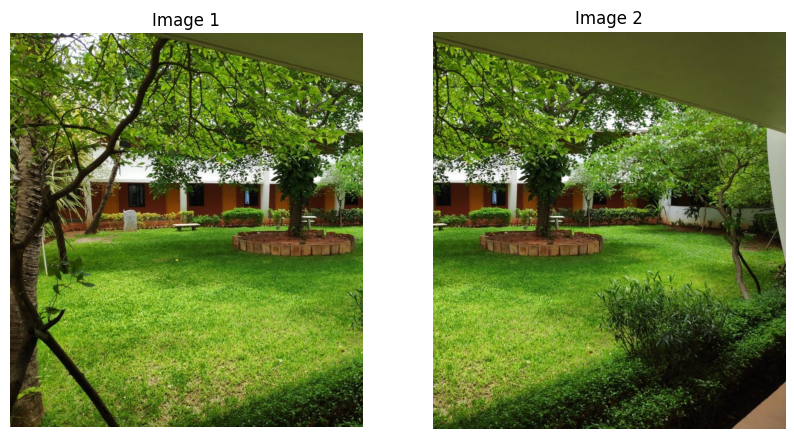

In [2]:
# Read input images
img_1 = cv2.imread('campus1.jpg')
img_2 = cv2.imread('campus2.jpg')

# Display input images 
fig, axes = plt.subplots(1, 2, figsize=(10,6))

# Display Image 1
axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1')
axes[0].axis('off')

# Display Image 2
axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.show()

###  SIFT Feature Matching

Using the SIFT algorithm, detected keypoints, computed descriptors, and computed a homography matrix for feature matching between the two images.

In [3]:
def sift_feature_matching(img1, img2):
    # Create SIFT object
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors for both images
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    # Create BFMatcher object
    bf = cv2.BFMatcher()

    # Match descriptors of keypoints in both images
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test to find good matches
    good = []
    for m in matches:
        if m[0].distance < 0.5 * m[1].distance:
            good.append(m)

    # Check if enough good matches are found
    matches = np.asarray(good)
    if len(matches[:, 0]) >= 4:
        # Get coordinates of matched keypoints
        src = np.float32([kp1[m.queryIdx].pt for m in matches[:, 0]]).reshape(-1, 1, 2)
        dst = np.float32([kp2[m.trainIdx].pt for m in matches[:, 0]]).reshape(-1, 1, 2)

        # Find homography matrix using RANSAC
        H, _ = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
        return H
    else:
        raise AssertionError('Can’t find enough keypoints.')

In [4]:
# Call sift_feature_matching function to find the homography matrix H
H = sift_feature_matching(img_1, img_2)

# Print the homography matrix H
print(H)

[[ 9.99889058e-01  2.81908393e-06 -4.28955139e+02]
 [-3.77540732e-05  9.99894656e-01  2.35052065e-02]
 [-1.28859983e-07 -9.12587628e-09  1.00000000e+00]]


### Image Stitching

In [5]:
def stitch_images(img_1, img_2, H):
    # Get dimensions of both images
    h1, w1 = img_1.shape[:2]
    h2, w2 = img_2.shape[:2]

    # Define corners of images as points
    pts1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    pts2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)

    # Transform points of the second image using the homography matrix
    pts2_ = cv2.perspectiveTransform(pts2, H)

    # Concatenate points of both images
    pts = np.concatenate((pts1, pts2_), axis=0)

    # Calculate minimum and maximum coordinates of stitched image
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)

    # Calculate translation matrix to shift the stitched image
    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])  # Translation matrix

    # Warp the first image using the homography matrix and translation matrix
    stitched_image = cv2.warpPerspective(img_1, Ht.dot(H), (xmax-xmin, ymax-ymin))

    # Paste the second image onto the warped area of the stitched image
    stitched_image[t[1]:h2+t[1], t[0]:w2+t[0]] = img_2

    return stitched_image

In [6]:
stitched_image = stitch_images(img_1, img_2, H)

### Display Stitched Output Image along with its Component Input Images

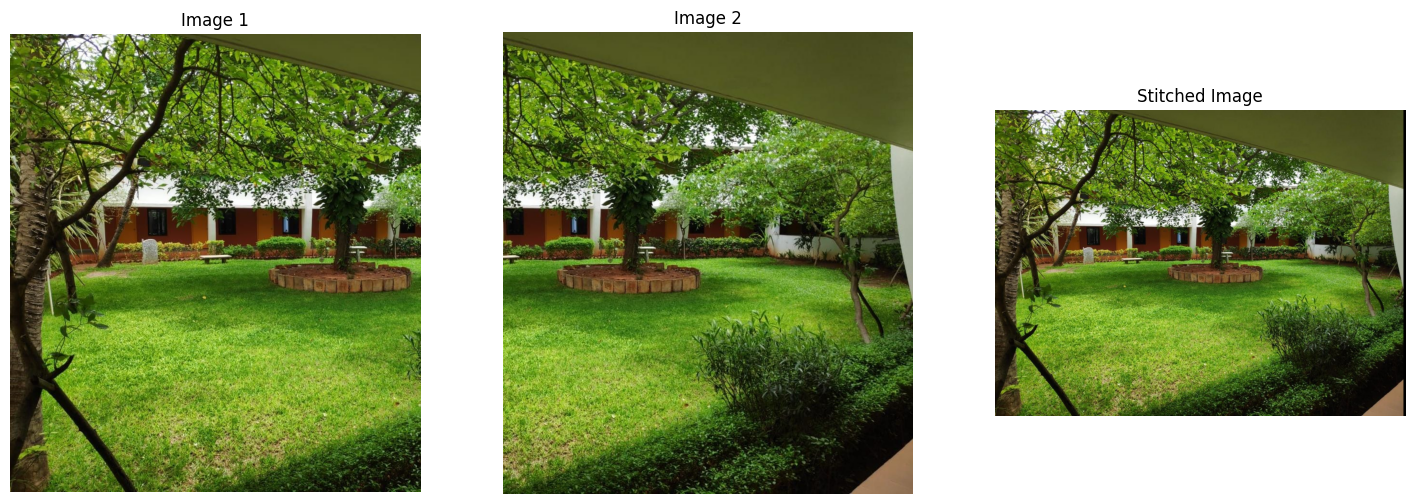

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display Image 1
axes[0].imshow(cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB))
axes[0].set_title('Image 1')
axes[0].axis('off')

# Display Image 2
axes[1].imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
axes[1].set_title('Image 2')
axes[1].axis('off')

# Display the stitched image
axes[2].imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
axes[2].set_title('Stitched Image')
axes[2].axis('off')

plt.show()